## Hurrican Research Division --> Atlantic Hurrican date from 1851 to 2024
- This notebook is intended to keep all data processing concise. To take the raw data and process it into usable data.
- The following section is transforming the data set, hurdat, a data set from the Hurricane Research Division. The data set came in a txt file with no column names. From there it is converted into a proccessed csv file and placed into the processed folder in the data folder.  
- Link : https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html

In [64]:
pip install geopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [geopy]
Note: you may need to restart the kernel to use updated packages.


In [65]:
import csv
import os

# Define file paths, take the raw unprocessed data and produce a cleaned CSV file placing it into processed folder
input_file = "../data/raw/hurdat2_atlantic.txt"
output_folder = "../data/processed"
output_file = os.path.join(output_folder, "hurdat2_atlantic.csv")

os.makedirs(output_folder, exist_ok=True)# Ensure the output directory exists

# Open the input file and output CSV file
with open(input_file, 'r') as f_in, open(output_file, 'w', newline='') as f_out:
    writer = csv.writer(f_out)
    
    writer.writerow(["Storm_id", "Storm_name", "Date", "Time", "Type_of_storm", "Latitude", "Longitude", "Wind_knots", "Pressure_mb"])
    
    current_id = ""
    current_name = ""
    
    for line in f_in: # Read each line in the input file
        line = line.strip() # Remove leading/trailing whitespace
        if not line: # Skip empty lines
            continue
        
        # Header line (storm start)
        if line[0].isalpha() and "," in line: # Identify header lines
            parts = line.split(",") # Split by comma
            current_id = parts[0].strip() # Storm ID
            current_name = parts[1].strip() # Storm name
            continue
        
        # Data line
        parts = [p.strip() for p in line.split(",")] # Split and strip each part
        if len(parts) >= 7: # Ensure there are enough parts
            date = parts[0] # Date
            time = parts[1] # Time
            type_ = parts[3] # Type of storm
            lat = parts[4] # Latitude
            lon = parts[5] # Longitude
            wind = parts[6] # Wind knots
            pressure = parts[7] if len(parts) > 7 else "" # Pressure in mb (if available)
            
            writer.writerow([current_id, current_name, date, time, type_, lat, lon, wind, pressure]) # Write to CSV


In [66]:
import pandas as pd      
import numpy as np       
atlantic_storm = pd.read_csv("../data/processed/hurdat2_atlantic.csv")
atlantic_storm['Date'] = atlantic_storm['Date'].astype('string') # Ensure date is string
atlantic_storm['Time'] = atlantic_storm['Time'].apply(lambda x: f"{int(x):04d}") # Ensure time is 4 digits

import pandas as pd
import numpy as np

# Convert Latitude (N/S)
atlantic_storm['Lat'] = atlantic_storm['Latitude'].str[:-1].astype(float)
atlantic_storm['Lat'] *= np.where(atlantic_storm['Latitude'].str[-1] == 'S', -1, 1)

# Convert Longitude (W/E)
atlantic_storm['Lon'] = atlantic_storm['Longitude'].str[:-1].astype(float)
atlantic_storm['Lon'] *= np.where(atlantic_storm['Longitude'].str[-1] == 'W', -1, 1)


atlantic_storm['Timestamp'] = pd.to_datetime(atlantic_storm['Date'] + atlantic_storm['Time'], format='%Y%m%d%H%M') # Combine date and time into a single timestamp
cols = ["Storm_id", "Storm_name", "Timestamp", "Type_of_storm", "Lat", "Lon", "Wind_knots", "Pressure_mb"]
atlantic_storm = atlantic_storm[cols] # Reorder columns
atlantic_storm.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55230 entries, 0 to 55229
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Storm_id       55230 non-null  object        
 1   Storm_name     55230 non-null  object        
 2   Timestamp      55230 non-null  datetime64[ns]
 3   Type_of_storm  55230 non-null  object        
 4   Lat            55230 non-null  float64       
 5   Lon            55230 non-null  float64       
 6   Wind_knots     55230 non-null  int64         
 7   Pressure_mb    55230 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 3.4+ MB


In [ ]:
# Wilmington bounding box
lat_min, lat_max = 34.0, 34.5
lon_min, lon_max = -78.0, -77.5

df_wilmington = atlantic_storm[
    (atlantic_storm['Lat'] >= lat_min) & (atlantic_storm['Lat'] <= lat_max) &
    (atlantic_storm['Lon'] >= lon_min) & (atlantic_storm['Lon'] <= lon_max)]

df_wilmington = df_wilmington[cols]


In [74]:
from geopy.distance import geodesic

# Example: Wilmington shelters
shelters = pd.DataFrame({
    'name': ['Shelter A', 'Shelter B'],
    'Lat': [34.22, 34.28],
    'Lon': [-77.94, -77.85]
})

# Compute distance (km) from each storm point to each shelter
def min_distance_to_shelters(storm_point):
    distances = [geodesic((storm_point['Lat'], storm_point['Lon']), (s['Lat'], s['Lon'])).km for _, s in shelters.iterrows()]
    return min(distances)

df_wilmington['min_distance_km'] = df_wilmington.apply(min_distance_to_shelters, axis=1)
df_wilmington.to_csv("../data/processed/hurdat2_wilmington.csv", index=False)


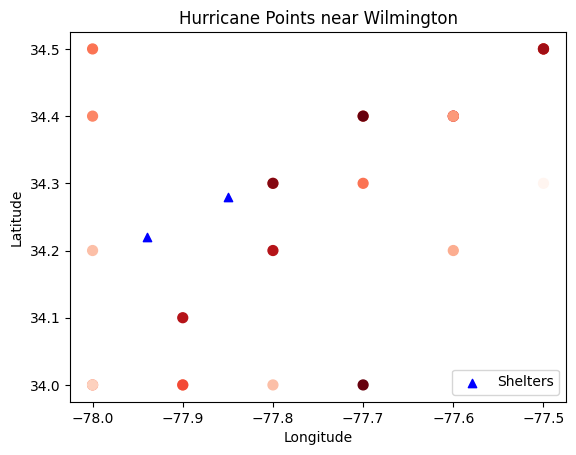

In [73]:
import matplotlib.pyplot as plt

plt.scatter(df_wilmington['Lon'], df_wilmington['Lat'], c=df_wilmington['Wind_knots'], cmap='Reds', s=50)
plt.scatter(shelters['Lon'], shelters['Lat'], marker='^', c='blue', label='Shelters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hurricane Points near Wilmington')
plt.legend()
plt.show()
